# PQTrees
#### Lev. G 2020 [GitHub](https://github.com/levgou/pqtrees)

![Wikipedia - example](./docs/images/wiki_pqtree.png)

### Project mostly based on the work described at:
* __Finding All Common Intervals of k Permutations:__ `docs/articles/Finding All Common Intervals of k Permutations.pdf`

* __Gene Proximity Analysis Across Whole Genomes via PQ Trees__: `docs/articles/Gene Proximity Analysis Across Whole Genomes via PQ Trees (2005) OrenWeimann.pdf`

## The project:
### This notebook is devided into a few subpartts as follows:

i. Common intervals   
ii. PQTrees    
iii. PQTrees extensions    
iv. Apendix   

Each part will provide an explanatiion, an implementation and further remarks

## Common Intervals 

### Glossary

#### 1. Common Intervals

For `k` permutation over the same alephabet, w.l.o.g over `[0..x]` and first permutation `p0` is `[0..x]`,
Common intervals are sub intervals of `p0` (for example `[1..3]`) tha appear together in all the permutation.

Trivial common intervals are all the singltons (because the permutations are over the same alphabet) - 
`[0,0]` ... `[x,x]`,   
and the whole permutation `[0,x]`

__Example:__   
For permutations `(0, 1, 2, 3, 4) ; 4, 3, 0, 2, 1)` the non trivial common intervals are:
`{ [1,2], [3,4], [0,2], [0,3] }`

#### 2. Irreducible intervals 
For `k` permutation as in `1.` irreducible intervals are a sub set of the common intervals set, 
that follow:  

Each interval that is not composable from any other intervals

__Composoble:__ An interval is said to be composble in the case there are some other intervals that overlap with at leasr 1 character and compose the said interval, for ex. composing `[2,4]` with `[3,5]` produces `[2,5]`

__Example:__ For athe following group of intervals:   
`{[1, 2], [1, 3], [1, 8], [1, 9], [2, 3], [4, 5], [4, 6], [4, 7], [4, 8], [4, 9], [5, 6] }`

The subset of irreducible intervlas is:   
`{[1, 2], [1, 8], [2, 3], [4, 5], [4, 7], [4, 8], [4, 9], [5, 6]}`


### Algorithms

In order to find all the common intervals, first a trivial algorithm was used - then amore eficient one was devised.

#### 1. Trivial algorithm

```python
for size in [1, ..., len(permutations[0])]:
    for w in sliding_window(permutations[0], size):
        char_set = set(w)
        if all(find_char_set(p, char_set) for p in permutations[1:]):
            common_intervals.add(w)

```

In [1]:
from pqtrees import trivial_common_k

permutations =  ((0, 1, 2, 3, 4), (4, 3, 0, 2, 1))
trivial_common_k(*permutations)

[CI[1, 2], CI[3, 4], CI[0, 2], CI[0, 3], CI[0, 4]]

#### 2. Optimized Algorithm

The optimized algorithm before searching a char_set in some pemutation - will index all the subsets of such permutation with the length of char_set - reducing the runtime of subsequent searched to `O(1)`.

Index generation is done lazily (the index is updated only upon first search of a certain length), to eliminate not needed proccessing when working with big anounts of permutations (more than 20-30).

The algorithm structure is very similar to `1.` but with indexing changes:

```python
for size in [1, ..., len(permutations[0])]:
    index = {}
    for w in sliding_window(permutations[0], size):
        char_set = set(w)
        if char_set_in_others(permutations[1:], char_set, index):
            common_intervals.add(w)

def char_set_in_others(others, char_set, index):
    for other in others:
        if other not in index:
            index_perm(index, other, len(char_set)
        if char_set not in index[other]:
            return False
    return True
                                      
def index_perm(index, perm, length):
    for w in sliding_window(perm, length):
        index[perm].add(set(w))
```

In [2]:
from pqtrees import common_k_indexed

permutations =  ((0, 1, 2, 3, 4), (4, 3, 0, 2, 1))
common_k_indexed(*permutations)

[CI[1, 2], CI[3, 4], CI[0, 2], CI[0, 3], CI[0, 4]]

#### 3. Benchmark
We want to measure the improvement of the second alg.
Thus we will run randomized examples on a large amount of long permutations and measure the times.

In [3]:
import random
from pprint import pprint
from pqtrees import time_runtime

REPEAT_TEST_TIMES = 150
LENGTH = 100
NUM_PERMS = 100

algs = [trivial_common_k, common_k_indexed]
names = [alg.__name__ for alg in algs]
total_times = {name: 0 for name in names}


for _ in range(REPEAT_TEST_TIMES):

    sig_a = list(range(LENGTH))
    other_perms = [list(sig_a) for _ in range(NUM_PERMS - 1)]
    for p in other_perms:
        random.shuffle(p)

    t_others = map(tuple, other_perms)

    for alg, alg_name in zip(algs, names):
        _, cur_rt = time_runtime(lambda: alg(sig_a, *t_others))
        total_times[alg_name] += cur_rt

print("\nRuntimes:")
pprint(total_times)



Runtimes:
{'common_k_indexed': 0.9768232009999549, 'trivial_common_k': 56.01877341199999}


## PQTree
![Wikipedia - example](./docs/images/wiki_pqtree.png)

### Glossary

#### PQtree
A rooted, ordered, tree consisting of __P__ nodes and __Q__ nodes, which represents a number of string, recursivly built from the __P__ and __Q__ rules bellow.

#### PNode (mnemonic - permutation node)
A __P__ node yield the strings that consist of all the permutations of it's children (leafs / inner nodes).

In the example tree above, the PNode yields: `(2,3,4), (2,4,3), (3,2,4), (3,4,2), (4,3,2), (4,3,2)`

#### QNode
A __Q__ node yield the strings that consits of it's children in their order, and in their reverse order.

In the example tree above, the Qnode yields: `(1, yield(P), 5), (5, yield(P), 1)`

#### Full example
If we combine both yields, as described aobve, the full yield of the example tree is:
`12345, 12435, 13245, 13425, 14235, 14325, 52341, 52431, 53241, 53421, 54231, 54321`

#### Parentheses representation
PQtrees could also be represented as parentheses where:
1. QNode is serrounded by `[ ]` brackets
2. PNode is sorrounded by `( )` brackets

Thus our example tree could be represented as: `[1 (2 3 4) 5]`

### Construction Algorithm

The construction algorithm is consisted of few steps.
For give `P = {p1, ... , pk}` permutation of `(1...x)` the steps are:

1. Compute the common intervals set of P - as described in the first section
2. Compute the irreducible intervals set (a strait forward alg. - description not attached)
3. From the irreducible intervals set - compue a data stracture called `S`
4. From `S` - construct the PQTree

#### Construction of  `S` from the set of irreducible intervals

![S data structure](./docs/images/s_data_stracture.png)

The structure as depicted above is a sort of the irreduvible intervals set by nesting level.

__Nesting Level:__ nesting level of an interval, is the amount of other intervals that include said interval (as sub interval)

As we can see in the example `[4,5]` has nesting level of 4 - because its included in `[4,7], [4,8], [1,8], [4,9]`

The alg. to perform such sorting is pretty strait forward:
1. sort the interval by size from large to small
2. For each interval in above order check if its included in the larger intervals, if so its nesting level is +1 of the first interval that includes it (the smallest one).

Because we're not dealing with hige amounts of intervals above alg. is sufficently efficient, although there are faster ways to compute the `S` data structure.

#### Construction of a PQTree from a  `S` data stracture

When constructing the tree we will iterate over `S` in a bottom order from left to right:

* If nestigLevel(x) > nestingLevel(y) then x shows up in the iteration before y
* If left(a) < left(b)  the a shows up in the iteration befoe b

While iteration over `S` we have 3 kind of cases for each interval:
![S iter pic](./docs/images/s_iter_cases_pic.png)

![S iter description](./docs/images/s_iter_description.png)


##### Case A
Trivial intervals in `S` - will be represented as leafs in the produced PQtree

##### Case B
* Will be represented as a QNode in the tree
* In the example (1,3)
* QNodes' children will be:
    * A child representing the intersection - in the example - 2
    * A child representing the items that are only in the left interval - 1
    * A child representing the items that are only in the right inreval - 3

We can see the _orange_ Qnode that will be produced from the highlited intervals:
![S iter description](./docs/images/qnode_example.png)

##### Case C
An intervals that is not a part of interval chain - will be represented as a PNode in the final tree

Note: PNode with 2 children - will be converted to a QNode as we can see happed to the _green_ interval:

![S iter description](./docs/images/pnode_example1.png)

##### Case C - Example with PNode produced ???????

### PQTree construction code example
We will show demonstrate the construction of the tree that is in the first Example

In [4]:
from pqtrees import common_k_indexed_with_singletons, ReduceIntervals, IntervalHierarchy, PQTreeBuilder, PQTree

perms = [(0, 1, 2, 3, 4), (0, 1, 3, 2, 4), (0, 2, 1, 3, 4),
         (0, 2, 3, 1, 4), (0, 3, 1, 2, 4), (0, 3, 2, 1, 4),
         (4, 1, 2, 3, 0), (4, 1, 3, 2, 0), (4, 2, 1, 3, 0),
         (4, 2, 3, 1, 0), (4, 3, 1, 2, 0), (4, 3, 2, 1, 0)]

common_intervals = common_k_indexed_with_singletons(*perms)
ir_intervals = ReduceIntervals.reduce(common_intervals)

s = IntervalHierarchy.from_irreducible_intervals(ir_intervals)
pqtree = PQTreeBuilder._from_s(s)

# Which is equivalent to:
perms_starting_1 = list(map(lambda perm: tuple(x + 1 for x in perm), perms))
pqtree = PQTreeBuilder.from_perms(perms_starting_1)
pqtree

PQ<[1 (2 3 4) 5]>

We can check the parenthesis representation and inspect the frontier:

In [5]:
pqtree.to_parens()

'[1 (2 3 4) 5]'

In [6]:
list(pqtree.frontier())

['12345',
 '52341',
 '12435',
 '52431',
 '13245',
 '53241',
 '13425',
 '53421',
 '14235',
 '54231',
 '14325',
 '54321']

And visualzie the tree:

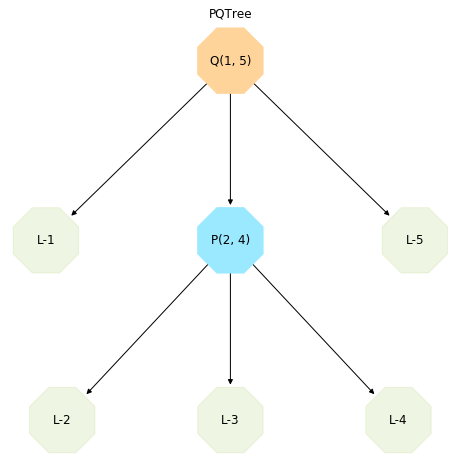

In [7]:
from pqtrees import PQTreeVisualizer

PQTreeVisualizer.show(pqtree)

We can also produce a Json representation for integration with other tools

In [8]:
print(pqtree.to_json(pretty=True, ommit_multi_info=True))

{
  "approx_front_size": 12,
  "root": {
    "type": "QNode",
    "children": [
      {
        "type": "LEAF",
        "char": "1"
      },
      {
        "type": "PNode",
        "children": [
          {
            "type": "LEAF",
            "char": "2"
          },
          {
            "type": "LEAF",
            "char": "3"
          },
          {
            "type": "LEAF",
            "char": "4"
          }
        ]
      },
      {
        "type": "LEAF",
        "char": "5"
      }
    ]
  }
}


## PQtree extensions

### PQtree with Multi Characters

One of the proposed extenssion to the PQTree, in this project is - dealing with characters that repeat but show up together.

We know that biologically - thandhem duplications are a frequent way of "character multiplications".

The proposition to solve this special case is to merge all the characters that are the same in to a __Multi Character__ , and solve the PQTree problem on the reduced string.

The leafs in the produced tree will contain the information of reduction done - thus we can represent the original string in the frontier of our tree (and others with such duplocation)

##### Example:
We will provide an example of such strings, and the full soulution of the problem bellow

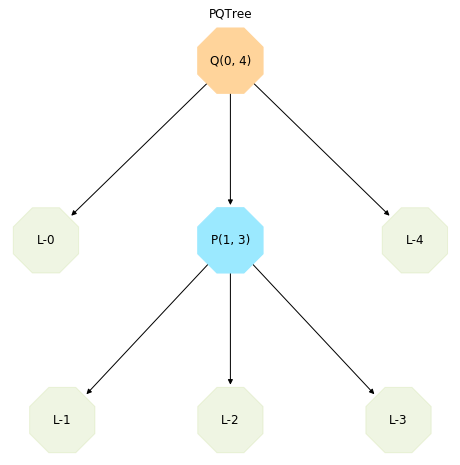

In [9]:
from pqtrees import PQTreeDup

perms = [(0, 1, 1, 2, 3, 4),     (0, 1, 3, 2, 4, 4),     (0, 2, 1, 3, 4),
         (0, 2, 3, 1, 1, 4),     (0, 3, 1, 2, 4, 4),     (0, 3, 2, 1, 4),
         (4, 1, 1, 2, 3, 0),     (4, 4, 1, 3, 2, 0),     (4, 2, 1, 3, 0),
         (4, 2, 3, 1, 1, 1, 0),  (4, 4, 4, 3, 1, 2, 0),  (4, 3, 2, 1, 0)]

perm_strs = [''.join(map(str, p)) for p in perms]

pqtree = PQTreeDup.from_perms_wth_multi(perms)
PQTreeVisualizer.show(pqtree)

As we can see we get the same tree structure as before,
but let us examine the frontier and the json representation.

In [10]:
from pprint import pprint

front = list(pqtree.frontier())
pprint(sorted(front, key=len), compact=True)

print(f'\nAll permutations in frontier: {all(p in front for p in perm_strs)}')

['01234', '41230', '01324', '41320', '02134', '42130', '02314', '42310',
 '03124', '43120', '03214', '43210', '012344', '441230', '013244', '441320',
 '021344', '442130', '023144', '442310', '031244', '443120', '032144', '443210',
 '011234', '411230', '011324', '411320', '021134', '421130', '023114', '423110',
 '031124', '431120', '032114', '432110', '0123444', '4441230', '0132444',
 '4441320', '0213444', '4442130', '0231444', '4442310', '0312444', '4443120',
 '0321444', '4443210', '0112344', '4411230', '0113244', '4411320', '0211344',
 '4421130', '0231144', '4423110', '0311244', '4431120', '0321144', '4432110',
 '0111234', '4111230', '0111324', '4111320', '0211134', '4211130', '0231114',
 '4231110', '0311124', '4311120', '0321114', '4321110', '01123444', '44411230',
 '01132444', '44411320', '02113444', '44421130', '02311444', '44423110',
 '03112444', '44431120', '03211444', '44432110', '01112344', '44111230',
 '01113244', '44111320', '02111344', '44211130', '02311144', '44231110',
 '0

As we can see, now the frontier also includes all the possible duplications of characters.

In [11]:
print(pqtree.to_json(pretty=True))

{
  "approx_front_size": 108,
  "root": {
    "type": "QNode",
    "children": [
      {
        "type": "LEAF",
        "char": "0",
        "multi": false,
        "multi_stats": {
          "1": "12:12"
        }
      },
      {
        "type": "PNode",
        "children": [
          {
            "type": "LEAF",
            "char": "1",
            "multi": true,
            "multi_stats": {
              "1": "8:12",
              "2": "3:12",
              "3": "1:12"
            }
          },
          {
            "type": "LEAF",
            "char": "2",
            "multi": false,
            "multi_stats": {
              "1": "12:12"
            }
          },
          {
            "type": "LEAF",
            "char": "3",
            "multi": false,
            "multi_stats": {
              "1": "12:12"
            }
          }
        ]
      },
      {
        "type": "LEAF",
        "char": "4",
        "multi": true,
        "multi_stats": {
          "1": "8:12"

We can see, that the characters that were reduced, retain the information of the original strings as fractions.

### PQTree with multiple occuraces of characters

Another problem we would like to address is when there are duplication of characters but they dont show up consequently in all of our permutations.

For example: 
```python
[
    (1, 2, 3, 1),
    (1, 2, 1, 3)
]
```

The soulution we propose, that doesnt do any assumptions about the "origins of the characters", meaning we do not provide a statement about "which `1` in the first perm is the same one as the `1` in the second", 
is to return a forest of PQTrees for each of these combinations.

Let us provide an example of all the combination for the above permutations:

```python
[
    [
        (1.1, 2, 3, 1.2),
        (1.1, 2, 1.2, 3)
    ],
    
    [
        (1.2, 2, 3, 1.1),
        (1.1, 2, 1.2, 3)
    ],
    
    [
        (1.1, 2, 3, 1.2),
        (1.2, 2, 1.1, 3)
    ],
    
    [
        (1.2, 2, 3, 1.1),
        (1.2, 2, 1.1, 3)
    ]
]
```

But if we examine closly, we can see that there is a duplication in our example.
We can see that bellow examples are equivalent:
```python
[
    (1.1, 2, 3, 1.2),
    (1.1, 2, 1.2, 3)
]

[
    (1.2, 2, 3, 1.1),
    (1.2, 2, 1.1, 3)
]
```

Thus in our computation the _order_ of the characters never changes in the first permutation, reducing the possibilities to:


```python
[
    [
        (1.1, 2, 3, 1.2),
        (1.1, 2, 1.2, 3)
    ],
    
    [
        (1.2, 2, 3, 1.1),
        (1.1, 2, 1.2, 3)
    ]
]
```

Lets examine the produced pqtree from above permutations

In [12]:
perms = [
    (1, 2, 3, 1),
    (1, 2, 1, 3)
]
perm_strs = [''.join(map(str, p)) for p in perms]

pqtree1, pqtree2 = list(PQTreeDup.from_perms(perms))

print(f"""
PQtree1: {pqtree1.to_parens()}, front size: {pqtree1.approx_frontier_size()} 
all perms in PQTree1's frontier: {all(p in pqtree1.frontier() for p in perm_strs)}
PQtree1 frontier: {list(pqtree1.frontier())}

PQtree2: {pqtree2.to_parens()}, front size: {pqtree2.approx_frontier_size()}
all perms in PQTree2's frontier: {all(p in pqtree2.frontier() for p in perm_strs)}
PQtree2 frontier: {list(pqtree2.frontier())}
""")


PQtree1: [1 2 [3 1]], front size: 4 
all perms in PQTree1's frontier: True
PQtree1 frontier: ['1231', '3121', '1213', '1321']

PQtree2: [[[1 2] 3] 1], front size: 8
all perms in PQTree2's frontier: True
PQtree2 frontier: ['1231', '1123', '3121', '1312', '2131', '1213', '3211', '1321']



We can see that the frontier size of above trees differs, thus we would suggest using one of the trees (or all of them) with the smallest frontier size - meaning it's the most conservative and still include the original permutations in their frontier.

### PQtree with multiple occuraces - context optimization
This enhancement is still a work in progress and has known examples that brake, which will be presented

Because above example is exponential in the number of permutations (actually its even worse if we have multiple characters that repeat) we would like to reduce the amount of possibilies we examine.

In otder to do so, the proposition is to join the repeating characters with another charcter that all the permutations agree on.

For example bellow permutations:
```python
perms = [
    (1, 2, 3, 1),
    (1, 2, 1, 3)
]
```

Will be transformed for example to:
```python
perms = [
    (1.2, 3, 1),
    (1.2, 1, 3)
]
```

In above case, the problem was reduced to the original PQtree problem, but sometims we still will need to produce PQtree forest.


After above reduction is done we would like to compute the pqtree, and than "break" the joint characters.
Let us examine an end to end example bellow:

In [13]:
perms = [
    (1, 2, 3, 5, 4, 1),
    (1, 2, 5, 1, 3, 4)
]
perm_strs = [''.join(map(str, p)) for p in perms]

pqtree, *rest = list(PQTreeDup.from_perms_with_merge(perms))
pqtree1, pqtree2 = list(PQTreeDup.from_perms(perms))

print(f"""
PQtree: {pqtree.to_parens()}, front size: {pqtree.approx_frontier_size()} 
all perms in PQTree's frontier: {all(p in pqtree.frontier() for p in perm_strs)}
""")

print(f"""
PQtree1: {pqtree1.to_parens()}, front size: {pqtree1.approx_frontier_size()} 
all perms in PQTree1's frontier: {all(p in pqtree1.frontier() for p in perm_strs)}

PQtree2: {pqtree2.to_parens()}, front size: {pqtree2.approx_frontier_size()}
all perms in PQTree2's frontier: {all(p in pqtree2.frontier() for p in perm_strs)}
""")


PQtree: [1 2 (3 5 4 1)], front size: 48 
all perms in PQTree's frontier: True


PQtree1: [1 2 (3 5 4 1)], front size: 48 
all perms in PQTree1's frontier: True

PQtree2: [[(1 2 3 5) 4] 1], front size: 96
all perms in PQTree2's frontier: True



We can in the above example, the we saved the computation of some tree, and still produced the optimal tree

Unfortianlty, while running randomized tests and comparing to the exponential method, we found examples that do not produce the optimal tree

In [14]:
perms = ((1, 2, 3, 4, 5, 6, 7, 7, 8, 9), (1, 2, 3, 6, 5, 7, 4, 7, 8, 9), (1, 2, 3, 4, 5, 6, 7, 8, 9, 7))


perm_strs = [''.join(map(str, p)) for p in perms]

pqtree, *rest = list(PQTreeDup.from_perms_with_merge(perms))
all_pqtrees = list(PQTreeDup.from_perms(perms))
best_pqtree = sorted(all_pqtrees, key=PQTree.approx_frontier_size)[0]

print(f"""
PQtree: {pqtree.to_parens()}, front size: {pqtree.approx_frontier_size()} 
all perms in PQTree's frontier: {all(p in pqtree.frontier() for p in perm_strs)}
""")

print(f"""
Best PQtree: {best_pqtree.to_parens()}, front size: {best_pqtree.approx_frontier_size()} 
all perms in Best PQTree's frontier: {all(p in best_pqtree.frontier() for p in perm_strs)}
""")

print(f"All pqtrees: {all_pqtrees}")


PQtree: [1 2 3 (4 [5 6] 7 [7 8 9])], front size: 192 
all perms in PQTree's frontier: True


Best PQtree: [1 2 3 [4 [[5 6] 7]] [7 [8 9]]], front size: 64 
all perms in Best PQTree's frontier: True

All pqtrees: [PQ<[1 2 3 [4 [[5 6] 7]] [7 [8 9]]]>, PQ<[1 2 3 (4 [5 6] 7 7 [8 9])]>, PQ<[1 2 3 (4 [5 6] 7 [7 8 9])]>, PQ<[1 2 3 (4 [5 6] 7 7 [8 9])]>]


We can see that the pqtree produced is one of th epossibilities of the exponential method, but not the most consevative one.

Work should still be done to understand such examples.

## Further work to be done

In case the reader is exersizing the idea of running the above algorithms on examples with many permutations and many duplications, the exponential method might no suffice.

This problem could be addresed in 2 ways:
1. We can imporove the runtime of construction of single exmaple - this route might be explored for long permutations, where finding all the common intervals might take substential time - we can see suggestions in `Finding All Common Intervals of k Permutations`.

    1.1 The common intervals problem could also be solved in `C` and interfaced via python


2. The context joining of charactes, could be further explored in order to understand whether its possible to produce the optimal example at all cases.

## Main contributions

### Implematation of the PQTree data stracture:
The implemenation is done in Python3, and its api is approachable and extendible.
The project is organized and published on GitHub

### Multi characters:
The implementation addresses the cases where the duplications are consequent well, and solves the construction of a PQTree for such cases

### General multiple occurances
The problem is solved in a simple way, but more advaced ways were exlored